# Punto 1
## Automatic identification of “trending/viral” topics around COVID in time in the World using deep learning architectures. Type: Different approaches.

In [1]:
import pickle as pk
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words
import umap.umap_ as umap


## Files used
The datasets and the embedings generated with a pretrained Sentence Bert model

In [2]:
#prefix = './drive/MyDrive/'
prefix = ''
spanish_path = prefix + 'datasets/spanish/spanish_out_hash_bien.json'
italian_path = prefix + 'datasets/italian/italian_out_hash_bien.json'
english_path = prefix + 'datasets/english/english_out_hash_bien.json'

#prefix = './drive/MyDrive/'
prefix = ''
italian_embeddings_path = prefix + 'models_hpc/embeddings_ita_hash.pickle'
spanish_embeddings_path = prefix + 'models_hpc/embeddings_es_hash.pickle'
english_embeddings_path = prefix + 'models_hpc/embeddings_en_hash.pickle'

#prefix = './drive/MyDrive/'
prefix = ''
umap_italian_embeddings_path = prefix + 'models_hpc/umap_ita_hash.pickle'
umap_spanish_embeddings_path = prefix + 'models_hpc/umap_es_hash.pickle'
umap_english_embeddings_path = prefix + 'models_hpc/umap_en_hash.pickle'


In [3]:
'''
------------------------ENGLISH---------------------------

------------------------ENGLISH---------------------------

------------------------ENGLISH---------------------------
'''

'\n------------------------ENGLISH---------------------------\n\n------------------------ENGLISH---------------------------\n\n------------------------ENGLISH---------------------------\n'

## English

In [3]:
file = open(english_path, 'r')
data = []
for line in file:
    data.append(json.loads(line))

text_raw_df = pd.json_normalize(data)

print(text_raw_df.shape)
text_raw_df.head(10)

(784932, 4)


,id,publication_date,source,text
0,1295929115770593287,1.597809e+09,twitter,Info Source:
1,1296738518216011777,1.598002e+09,twitter,#PostponeJEE_NEETSept #ProtestAgainstExamsInCO...
2,1252450676015198210,1.587442e+09,twitter,Coronavirus-spreader Chris Cuomo got a lecture...
3,1380684968880406528,1.618016e+09,twitter,Any military member that refuses to get vaccin...
4,1368958702150156290,1.615220e+09,twitter,#Covid19 is staying around for a while. your ...
5,1317169175203401735,1.602873e+09,twitter,LIES!!! LIES!!!
6,1288154256449708032,1.595955e+09,twitter,"@GregMannarino Deborah BirxWhite House ""Expert"""
7,1283867253222502400,1.594933e+09,twitter,Kayleigh McEnany: ‘Science Should Not Stand in...
8,1286909343909240832,1.595658e+09,twitter,Amazing effort from the guys! Please donate if...
9,1235895985009811461,1.583496e+09,twitter,@SulaiOdus They said it was suspended due to c...


In [4]:
'''
Turn text to Numpy Array
'''
texts_column = text_raw_df.loc[:,'text']
raw_texts = texts_column.values
raw_texts[0]

'Info Source: '

In [5]:
with open(english_embeddings_path, "rb") as output_file:
    embeddings = pk.load(output_file)

with open(umap_english_embeddings_path, "rb") as output_file:
    umap_embeddings = pk.load(output_file)

### HDBSCAN para el clustering

In [16]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=70,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

### Visualisación de los clusters

In [56]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(umap_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### c-TF-IDF

In [17]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [18]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=get_stop_words('english')).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

/Users/isabelasarmiento/pythonProject/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [19]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
10,9,769824
8,7,12326
0,-1,1487
6,5,375
3,2,205
2,1,164
4,3,147
1,0,110
5,4,105
9,8,95


In [21]:
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print('Topic #' + str(topic) +":"+ '\n')
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')


Topic #9:

['covid', '19', 'coronavirus', 'covid19', 'new', 'cases', 'people', 'will', 'trump', 'can']

Topic #7:

['china', 'chinese', 'coronavirus', 'wuhan', 'virus', 'covid', 'outbreak', '19', 'world', 'beijing']

Topic #5:

['empower', '090', 'entertain', '0208', '2121', 'educate', 'hello', 'air', 'talk', 'fantasticradio']

Topic #2:

['appointments', '00', 'cvs', 'near', 'pa', '04', 'sign', 'available', 'vaccination', '2021']

Topic #1:

['spain', 'strict', 'worn', 'outdoors', 'masks', 'lockdown', 'must', 'inside', 'spanish', 'extremely']

Topic #3:

['dictates', 'boris', 'interact', 'normal', 'many', 'johnson', 'peacefully', 'can', 'new', 'dictate']

Topic #0:

['viruscases', 'projections', 'recovered', 'united', 'closed', 'corona', 'states', 'cases4', 'cases6', 'cases1']

Topic #4:

['fantasticradio', '2121', '0208', 'adding', 'value', 'hello', '90', 'air', 'talk', 'co']

Topic #8:

['cvs', 'danville', '24540', 'emporia', '23847', 'alexandria', 'portsmouth', 'roanoke', 'abingdon

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


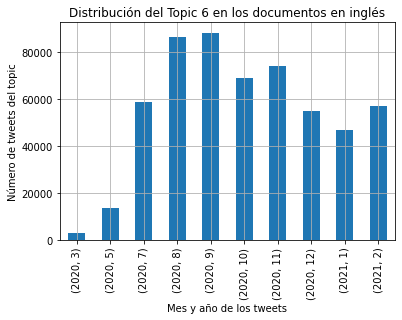

In [27]:
from datetime import datetime


text_raw_df['dates'] =  text_raw_df['publication_date'].apply(lambda x:  datetime.fromtimestamp(x))
text_raw_df['Topic'] = cluster.labels_
text_raw_df

for num_topic in topic_sizes['Topic']:
    ax = text_raw_df.groupby([text_raw_df['Topic'], text_raw_df['dates'].dt.year, text_raw_df['dates'].dt.month]).count()['id'][num_topic].plot(kind="bar") #Imprime el topic cero
    ax.grid(b=True, axis='both')
    print(type(ax))
    ax.set_title('Distribución del Topic ' + str(num_topic) + ' en los documentos en inglés')
    ax.set_xlabel('Mes y año de los tweets')
    ax.set_ylabel('Número de tweets del topic')


In [ ]:
'''
------------------------SPANISH---------------------------

------------------------SPANISH---------------------------

------------------------SPANISH---------------------------
'''

## SPANISH

In [57]:
file = open(spanish_path, 'r')
data = []
for line in file:
    data.append(json.loads(line))
text_raw_df = pd.json_normalize(data)

print(text_raw_df.shape)
text_raw_df.head(10)

(845125, 4)


,id,publication_date,source,text
0,1304391319972790274,1.599826e+09,twitter,ORACIÓN DIARIAViernes 11 de Septiembre 2020#or...
1,1308823479077175297,1.600883e+09,twitter,Se pudrió todo. Acá la FIFA debe castigar a la...
2,1255929719893221377,1.588272e+09,twitter,Última Publicación en la Prensaldia - @ca...
3,1367024221319286784,1.614759e+09,twitter,Australia = 0 positivos por coronavirus.¿Vacun...
4,1278689023087849480,1.593698e+09,twitter,coronavirus esto ya es personal
5,1374234992969015297,1.616478e+09,twitter,"#LadyZopilota, zopiloteando en la noticia."
6,1296604758732570625,1.597970e+09,twitter,La noticia que esperaban los mercados. Gracias...
7,1344926278592438272,1.609490e+09,twitter,No caigamos en la trampa.En México ya iniciaro...
8,1311046706809786372,1.601413e+09,twitter,El coronavirus se ha confirmado ya en más de 2...
9,1257004539875667971,1.588528e+09,twitter,@JaimeChincha @RPPNoticias Mi padre acaba de m...


In [23]:
'''
Turn text to Numpy Array
'''
texts_column = text_raw_df.loc[:,'text']
raw_texts = texts_column.values
raw_texts[0]


'ORACIÓN DIARIAViernes 11 de Septiembre 2020#oraciondiaria #11DeSeptiembre #BuenosDias #BuenosDiasATodos… '

In [28]:
with open(spanish_embeddings_path, "rb") as output_file:
    embeddings = pk.load(output_file)

with open(umap_spanish_embeddings_path, "rb") as output_file:
    umap_embeddings = pk.load(output_file)

### HDBSCAN para el clustering

In [54]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=80,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

### Visualisación de los clusters

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### c-TF-IDF

In [32]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [34]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=get_stop_words('spanish')).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [35]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,366501
583,582,50763
608,607,32008
617,616,25974
643,642,24022
645,644,14838
637,636,14768
41,40,6530
10,9,5855
75,74,5439


In [36]:
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')

['19', 'covid', 'vacuna', 'positivo', 'salud', 'pandemia', 'casos', 'si', 'pacientes', 'vacunas']

['coronavirus', 'si', 'gente', 'puede', 'va', 'positivo', 'vacuna', 'casos', 'caso', 'ser']

['covid19', 'pandemia', 'si', 'salud', 'vacuna', 'positivo', 'hoy', 'medidas', 'casos', 'vacunas']

['si', 'bien', 'gente', 'ser', 'va', 'salud', 'así', 'mierda', 'ver', 'día']

['si', 'ser', 'puede', 'gente', 'sé', 'puedo', 'hacer', 'bien', 'ver', 'verdad']

['salud', 'si', 'gracias', 'gobierno', 'lopezobrador_', 'nicolasmaduro', 'pandemia', 'ivanduque', 'hoy', 'hlgatell']

['venezuela', '19', 'covid', 'casos', 'nuevos', 'fallecidos', 'contagios', 'covid19', 'maduro', 'caracas']

['cuba', '19', 'covid', 'covid19', 'cubanos', 'casos', 'cubana', 'cubasalvavidas', 'cubaporlasalud', 'nuevos']

['china', 'coronavirus', 'wuhan', 'muertos', 'virus', 'brote', 'nuevo', 'vacuna', 'oms', 'origen']

['gracias', 'dios', 'vamos', 'bien', 'si', 'excelente', 'siempre', 'fuerza', 'grande', 'madre']

['presidente'

In [ ]:
'''
------------------------ITALIAN---------------------------

------------------------ITALIAN---------------------------

------------------------ITALIAN---------------------------
'''

## ITALIAN

In [58]:
file = open(italian_path, 'r')
data = []
for line in file:
    data.append(json.loads(line))
text_raw_df = pd.json_normalize(data)

print(text_raw_df.shape)
text_raw_df.head(10)

(814485, 4)


,id,publication_date,source,text
0,1324811856859533313,1.604695e+09,twitter,Il prof. #Galli è molto preoccupato da quanto ...
1,1288746494368124928,1.596096e+09,twitter,Il COVID-19 coincide con un momento cruciale n...
2,1326191597785059329,1.605024e+09,twitter,Muoviamoci #vaccinoCovid #coronavirus #COVID19...
3,1275134048722132993,1.592851e+09,twitter,@mosllerdd @Cartabellotta Si sarebbero potute ...
4,1243118079091118080,1.585217e+09,twitter,@morzo6 @CNN Purtroppo sì. State a casa. Disin...
5,1267645840455278594,1.591065e+09,twitter,"@orticArya * ""il coronavirus non c'è più, ma c..."
6,1233340720460726272,1.582886e+09,twitter,"Coronavirus, l’ultima trovata: mascherine grif..."
7,1279712208612667393,1.593942e+09,twitter,"""Penne in quarantena"". Tredici #racconti di al..."
8,1271709738301095936,1.592034e+09,twitter,"Cina, torna l’incubo Coronavirus: alcuni quart..."
9,1296853994686513152,1.598029e+09,twitter,Questo è il punto


In [59]:
'''
Turn text to Numpy Array
'''
texts_column = text_raw_df.loc[:,'text']
raw_texts = texts_column.values
raw_texts[0]

'Il prof. #Galli è molto preoccupato da quanto sta accadendo a #Milano '

In [60]:
with open(italian_embeddings_path, "rb") as output_file:
    embeddings = pk.load(output_file)

with open(umap_italian_embeddings_path, "rb") as output_file:
    umap_embeddings = pk.load(output_file)

### HDBSCAN para el clustering

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=1000,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

### Visualisación de los clusters

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### c-TF-IDF

In [77]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [78]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=get_stop_words('italian')).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [79]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,280218
143,142,115039
144,143,83892
105,104,41980
87,86,19636
80,79,13806
137,136,11494
149,148,10350
115,114,9697
10,9,9557


In [80]:
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')


['coronavirus', 'emergenza', 'positivo', 'via', 'governo', 'conte', 'caso', 'due', 'nuovo', 'cosa']

['cosa', 'solo', 'quando', 'essere', 'fa', 'sempre', 'poi', 'fatto', 'prima', 'così']

['covid19', 'emergenza', 'italia', 'pandemia', 'solo', 'prima', 'dopo', 'positivo', 'cosa', 'governo']

['19', 'covid', 'covid_19', 'positivo', 'emergenza', 'pandemia', 'positivi', 'via', 'dopo', 'nuovo']

['covid19', 'covid_19', 'coronavirus', '19', 'coronavirusitalia', 'covid', 'covid19italia', 'covid2019', 'coronarvirusitalia', 'pandemia']

['nuovi', 'casi', 'morti', 'positivi', 'italia', '24', 'bollettino', 'decessi', 'coronavirus', 'ore']

['sempre', 'eh', 'merda', 'modi', 'così', 'amo', 'schifo', 'dio', 'cosa', 'cazzo']

['italia', 'coronavirus', 'italiani', 'italiano', 'italiane', 'cina', 'contagi', 'tutta', 'casi', 'governo']

['2020', '2021', 'coronavirus', 'bollettino', 'dati', '2019', 'marzo', 'aprile', 'aggiornamento', 'oggi']

['fase', 'seconda', 'secondo', 'coronavirus', 'ondata', 'fase2